# 데이터 불러오기

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
obesity_df = pd.read_csv("/content/drive/MyDrive/KDT/프로젝트/세미 프로젝트/data/ObesityDataSet_Labeled_merge.csv")
obesity_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,2,1,24.386526
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,2,1,24.238227
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,2,1,23.765432
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,3,2,26.851852
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,2,3,28.342381


In [6]:
obesity_df.shape

(2111, 18)

# 파이썬 래퍼_XGBoost

## 데이터 분할

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Train - Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    obesity_df.drop(["BMI", "NObeyesdad"], axis=1),
    obesity_df['NObeyesdad'],
    random_state=42,
    stratify=obesity_df['NObeyesdad']
)


# Train - Valid 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, random_state=42
)

X_train.shape, X_valid.shape, X_test.shape

((1187, 16), (396, 16), (528, 16))

In [8]:
X_train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
612,0,23.018443,1.584785,44.376637,0,0,2.204914,2.127797,2,0,2.120292,0,0.995735,0.0,0,2
289,1,19.000000,1.880000,79.000000,0,0,2.000000,3.000000,1,0,3.000000,0,3.000000,0.0,1,1
932,1,22.828435,1.710415,75.142858,1,1,2.786008,3.000000,1,0,2.526193,0,0.925118,2.0,1,2
586,0,18.000000,1.700000,50.000000,0,1,1.031149,3.000000,1,0,1.963628,0,0.028202,1.0,1,2
197,1,41.000000,1.750000,118.000000,1,1,2.000000,3.000000,1,0,2.000000,0,0.000000,0.0,1,3


### 디폴트 값
- max_depth : 6   
- eta : 0.3   
- num_rounds : 400

## 훈련 및 학습

In [9]:
import time

start_time = time.time()

# XGBoost 돌릴때 전용 데이터 객체인 DMatrix 생성하기
d_train = xgb.DMatrix(data=X_train, label=y_train)
d_valid = xgb.DMatrix(data=X_valid, label=y_valid)
d_test  = xgb.DMatrix(data=X_test, label=y_test)

params = {
    'max_depth': 6, # 각 나무의 최대깊이
    'eta': 0.3, # 학습률(learning rate)
    'objective': 'multi:softmax', # 목적 함수(모델이 예측의 결과를 어떻게 표현할지를 지정하는 함수). logistic 함수를 사용하기 때문에 확률로 결과물을 내어준다.
    'num_class': 7, # 매개변수로 즉, 레이블에 있는 클래스의 개수를 나타내줌
    'eval_matric': 'mlogloss' # 다중분류인 경우 merror를 사용
    }


# 학습 횟수
num_rounds = 400

eval_list = [
    (d_train, 'train'),
    (d_valid, 'eval')
]

xgb_model = xgb.train(
    params=params, # 하이퍼 파라미터가 들어있는 딕셔너리
    dtrain = d_train, # 훈련 데이터 Feature + Label
    num_boost_round=num_rounds, # 훈련 횟수
    early_stopping_rounds=50, # 성능 개선(Loss가 낮아지면 성능이 개선됨)이 50라운드 이내에 이루어지지 않으면 학습을 종료
    evals = eval_list # 검증 세트 지정. 여기에서는 훈련 세트와 검증세트에 대한 성능을 한꺼번에 확인
)

end_time = time.time()

# 학습 소요 시간 계산
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

[0]	train-mlogloss:1.22650	eval-mlogloss:1.24691
[1]	train-mlogloss:0.88682	eval-mlogloss:0.92239
[2]	train-mlogloss:0.67535	eval-mlogloss:0.72515
[3]	train-mlogloss:0.53088	eval-mlogloss:0.59208
[4]	train-mlogloss:0.41557	eval-mlogloss:0.48471
[5]	train-mlogloss:0.33252	eval-mlogloss:0.40922
[6]	train-mlogloss:0.26974	eval-mlogloss:0.35125
[7]	train-mlogloss:0.22067	eval-mlogloss:0.30577
[8]	train-mlogloss:0.18201	eval-mlogloss:0.27125
[9]	train-mlogloss:0.15286	eval-mlogloss:0.24640
[10]	train-mlogloss:0.12727	eval-mlogloss:0.22160
[11]	train-mlogloss:0.10914	eval-mlogloss:0.20561
[12]	train-mlogloss:0.09389	eval-mlogloss:0.19156
[13]	train-mlogloss:0.08238	eval-mlogloss:0.18053
[14]	train-mlogloss:0.07162	eval-mlogloss:0.17021
[15]	train-mlogloss:0.06209	eval-mlogloss:0.16024
[16]	train-mlogloss:0.05455	eval-mlogloss:0.15173
[17]	train-mlogloss:0.04855	eval-mlogloss:0.14609
[18]	train-mlogloss:0.04256	eval-mlogloss:0.13899
[19]	train-mlogloss:0.03817	eval-mlogloss:0.13488
[20]	train

85번째에 eval-mlogloss가 .09657로 가장 낮음
- logloss는 작을수록 성능이 좋은것으로 85번째 이후 값이 더이상 향상되지 않기에 134번째에 중단됨


## 예측

In [10]:
import numpy as np

# 모델 만들 때 objective 함수를 logistic으로 지정했기 때문에 예측 시 확률 형식으로 예측 됨
pred_props = xgb_model.predict(d_test)
print(np.round(pred_props[:10], 3)) # 양성(1)으로 분류될 확률

[5. 0. 5. 4. 5. 2. 2. 1. 2. 4.]


## 성능평가

In [11]:
# 오차행렬
from sklearn.metrics import confusion_matrix

y_matrix = confusion_matrix(y_test, pred_props)
print("오차 행렬 : \n{}".format(y_matrix))

# 종속이 다중분류라 average를 'macro'를 부여
# https://data-minggeul.tistory.com/11 참고
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(pred_props, y_test)
precision = precision_score(pred_props, y_test, average='macro')
recall = recall_score(pred_props, y_test, average='macro')
f1 = f1_score(pred_props, y_test, average='macro')

print("정확도 : {}".format(accuracy))
print("정밀도 : {}".format(precision))
print("재현율 : {}".format(recall))
print("F1 : {}".format(f1))


오차 행렬 : 
[[63  5  0  0  0  0  0]
 [ 2 67  3  0  0  0  0]
 [ 0  5 66  2  0  0  0]
 [ 0  0  2 67  3  0  0]
 [ 0  0  0  0 88  0  0]
 [ 0  0  0  0  2 72  0]
 [ 0  0  0  0  0  1 80]]
정확도 : 0.9526515151515151
정밀도 : 0.9503312260497326
재현율 : 0.9532129322722562
F1 : 0.9513535577038549


## 피처중요도

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

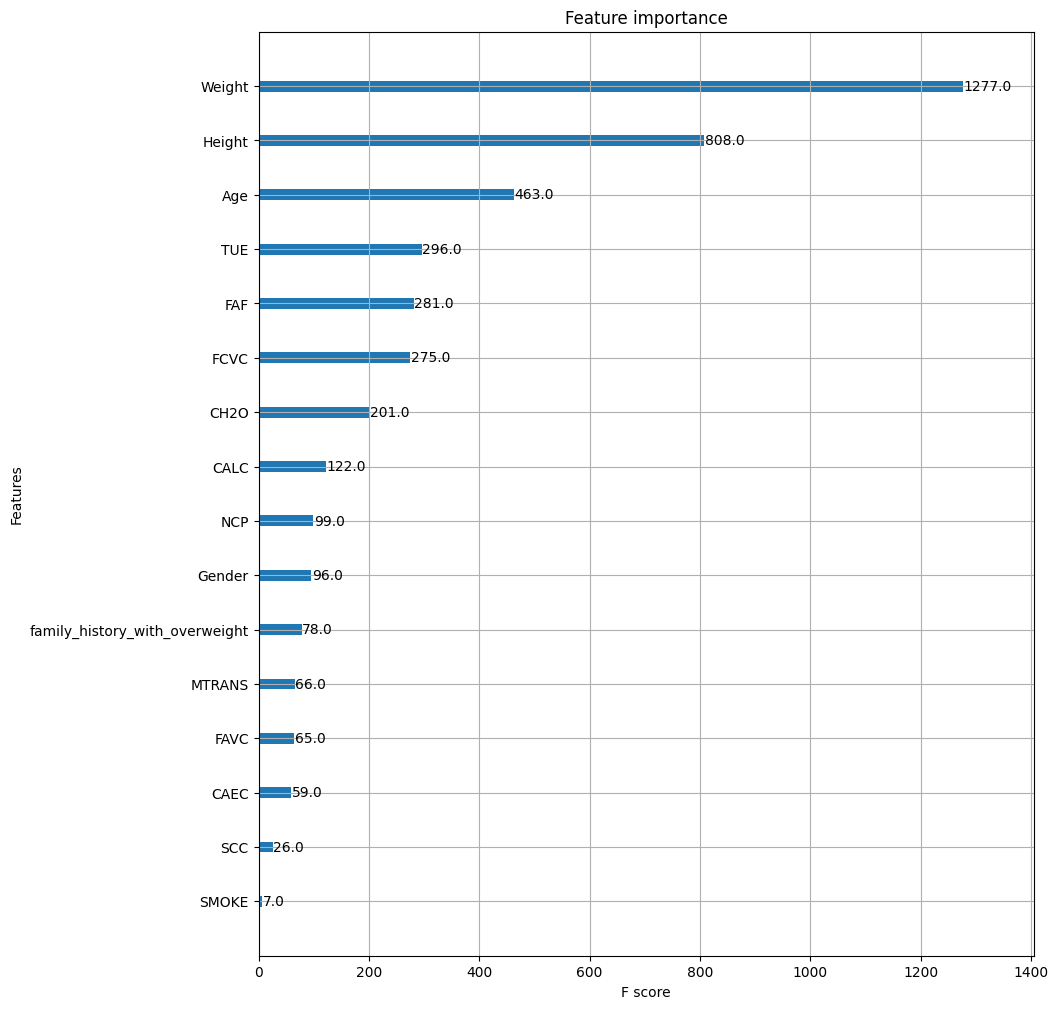

In [12]:
# feature importance

from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

해당 피처 중요도를 그리는 막대그래프는 기본 평가 질표로 f1를 기반으로 해당 피처의 중요도를 나타냄    
- f1은 해당 피처가 트리 분할 시 얼마나 자주 사용되었는지를 지표로 나타낸 값!

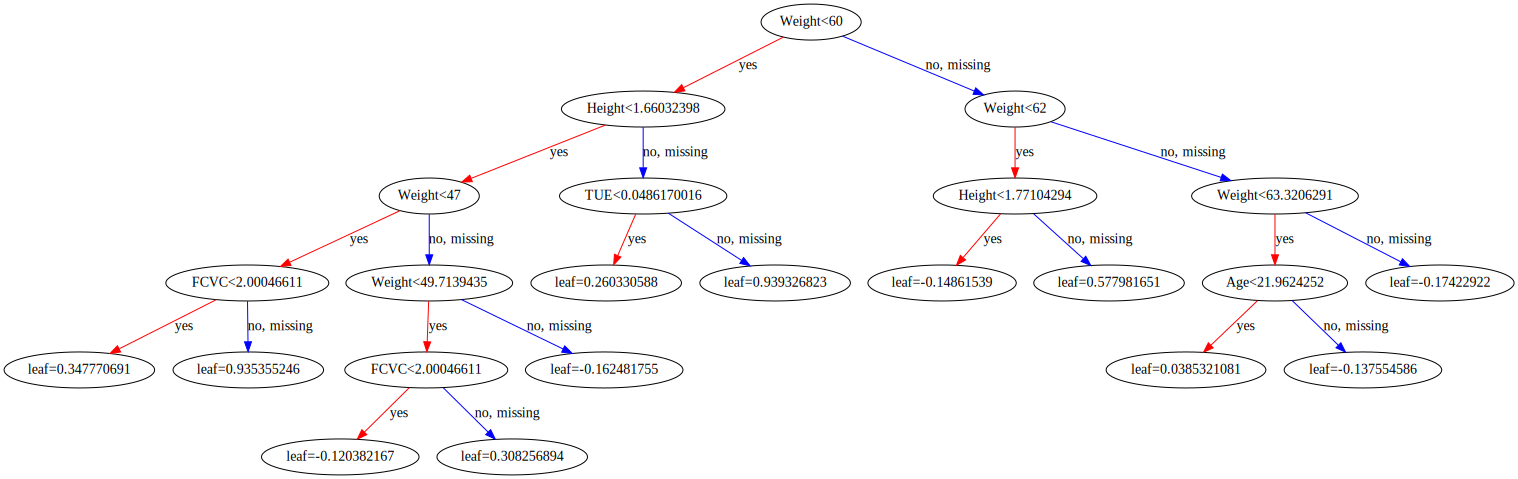

In [13]:
from xgboost import to_graphviz
import graphviz

to_graphviz(xgb_model)

# 싸이킷런 래퍼

## 조기중단 X

In [14]:
import time
from xgboost import XGBClassifier

# 학습 시작 시간 기록
start_time = time.time()

xgb_clf_x = XGBClassifier(
    n_estimators=400, # 학습할 학습기의 개수(훈련 횟수)
    learning_rate=0.1, # 학습률
    max_depth=6,
    eval_metric='mlogloss'
)

# 훈련
xgb_clf_x.fit(X_train, y_train, verbose=True) # verbose : 로그 출력 여부

end_time = time.time()

# 학습 소요 시간 계산
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

# 사이킷런의 predict : 결정된 클래스가 나옴
preds = xgb_clf_x.predict(X_test)
preds[:10]

Training time: 1.1661550998687744 seconds


array([5, 0, 5, 4, 5, 2, 2, 1, 2, 4])

In [15]:
# 성능 평가하기
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(preds, y_test)
precision = precision_score(preds, y_test, average='macro')
recall = recall_score(preds, y_test, average='macro')
f1 = f1_score(preds, y_test, average='macro')

print("정확도 : {}".format(accuracy))
print("정밀도 : {}".format(precision))
print("재현율 : {}".format(recall))
print("F1 : {}".format(f1))

정확도 : 0.9507575757575758
정밀도 : 0.9483735442975304
재현율 : 0.95131578654375
F1 : 0.9495074334609058


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

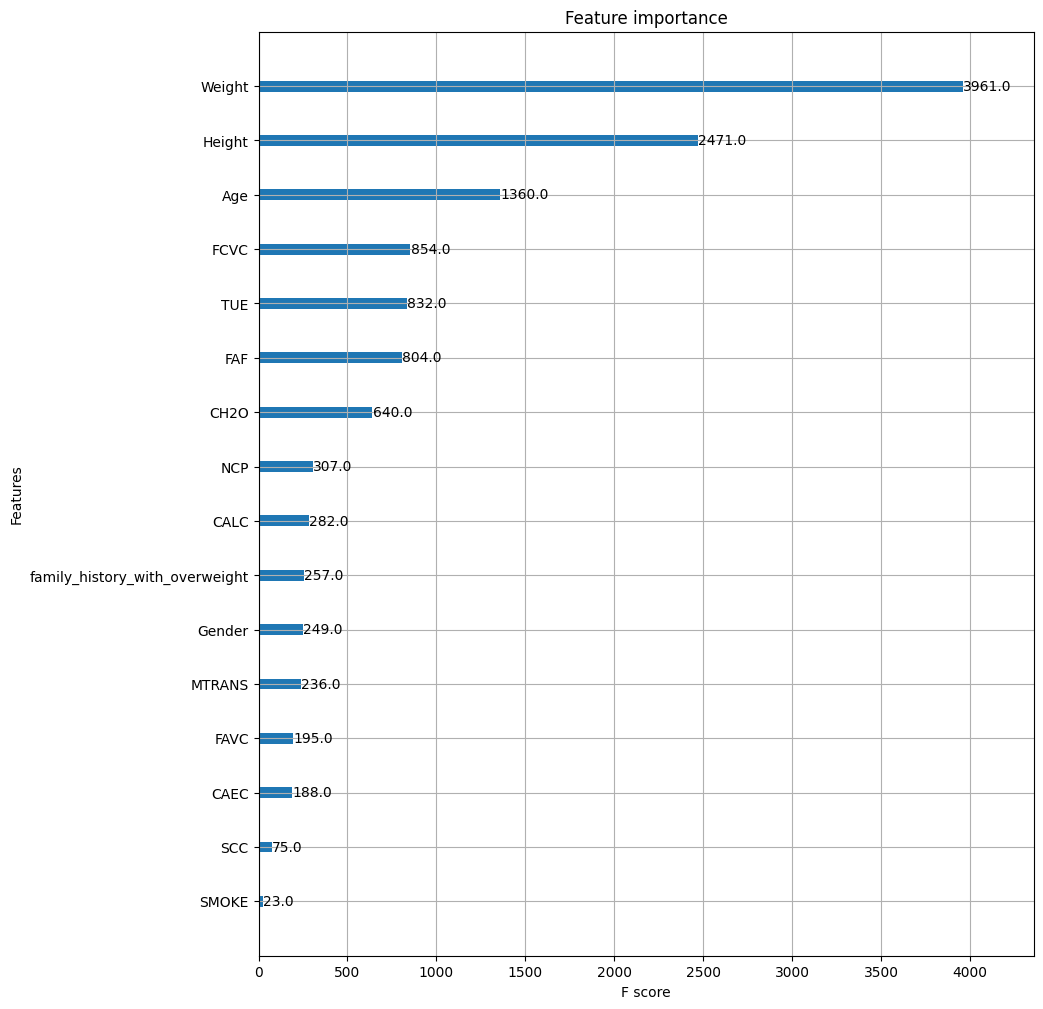

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_clf_x, ax=ax)

## 조기중단 O

In [17]:
import time
from xgboost import XGBClassifier

# 학습 시작 시간 기록
start_time = time.time()

# Early Stopping
xgb_clf_o = XGBClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=6,
    eval_metric='mlogloss'
)

# 검증 세트를 따로 지정

# eval_sets : 검증 데이터 목록
# (Train), (Valid) : 훈련 세트로 검증을 하고, 검증 세트로 검증
#   훈련 세트로 검증 : 학습한 내용에 대한 검증을 수행( 알고 있는 데이터에 대한 검증 )
#   검증 세트로 검증 : 모르는 내용에 대한 검증을 수행

#  두 개를 같이 하는 이유 : 과대 적합인지 확인하기 위해
eval_sets = [
    (X_train, y_train),
    (X_valid, y_valid)
]

xgb_clf_o.fit(
    X_train, y_train,
    early_stopping_rounds=50,
    eval_set = eval_sets,
    verbose=True
)


# 학습 종료 시간 기록
end_time = time.time()

# 학습 소요 시간 계산
training_time = end_time - start_time
print("Training time:", training_time, "seconds")


[0]	validation_0-mlogloss:1.68703	validation_1-mlogloss:1.69381
[1]	validation_0-mlogloss:1.49097	validation_1-mlogloss:1.50535
[2]	validation_0-mlogloss:1.33539	validation_1-mlogloss:1.35686
[3]	validation_0-mlogloss:1.19605	validation_1-mlogloss:1.22279
[4]	validation_0-mlogloss:1.07734	validation_1-mlogloss:1.10923
[5]	validation_0-mlogloss:0.97535	validation_1-mlogloss:1.01110
[6]	validation_0-mlogloss:0.88892	validation_1-mlogloss:0.92926
[7]	validation_0-mlogloss:0.81181	validation_1-mlogloss:0.85747
[8]	validation_0-mlogloss:0.74853	validation_1-mlogloss:0.79893
[9]	validation_0-mlogloss:0.68685	validation_1-mlogloss:0.74048
[10]	validation_0-mlogloss:0.63548	validation_1-mlogloss:0.69258
[11]	validation_0-mlogloss:0.58536	validation_1-mlogloss:0.64531
[12]	validation_0-mlogloss:0.53882	validation_1-mlogloss:0.60069
[13]	validation_0-mlogloss:0.49758	validation_1-mlogloss:0.56278
[14]	validation_0-mlogloss:0.45915	validation_1-mlogloss:0.52693
[15]	validation_0-mlogloss:0.42616	

275에서 가장 작은 0.09491를 확인하고 더이상 성능이 나아지는 것을 보지 못함

In [18]:
# 사이킷런의 predict : 결정된 클래스가 나옴
final_preds = xgb_clf_o.predict(X_test)
final_preds[:10]

array([5, 0, 5, 4, 5, 2, 2, 1, 2, 4])

In [19]:
y_matrix = confusion_matrix(y_test, final_preds)
print("오차 행렬 : \n{}".format(y_matrix))

# 성능 평가하기
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(final_preds, y_test)
precision = precision_score(final_preds, y_test, average='macro')
recall = recall_score(final_preds, y_test, average='macro')
f1 = f1_score(final_preds, y_test, average='macro')

print("정확도 : {}".format(accuracy))
print("정밀도 : {}".format(precision))
print("재현율 : {}".format(recall))
print("F1 : {}".format(f1))

오차 행렬 : 
[[63  5  0  0  0  0  0]
 [ 2 66  4  0  0  0  0]
 [ 0  4 67  2  0  0  0]
 [ 0  0  1 67  4  0  0]
 [ 0  0  0  0 88  0  0]
 [ 0  0  0  0  3 71  0]
 [ 0  0  0  0  0  1 80]]
정확도 : 0.9507575757575758
정밀도 : 0.9483735442975304
재현율 : 0.9518896740178204
F1 : 0.9497086198816067


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

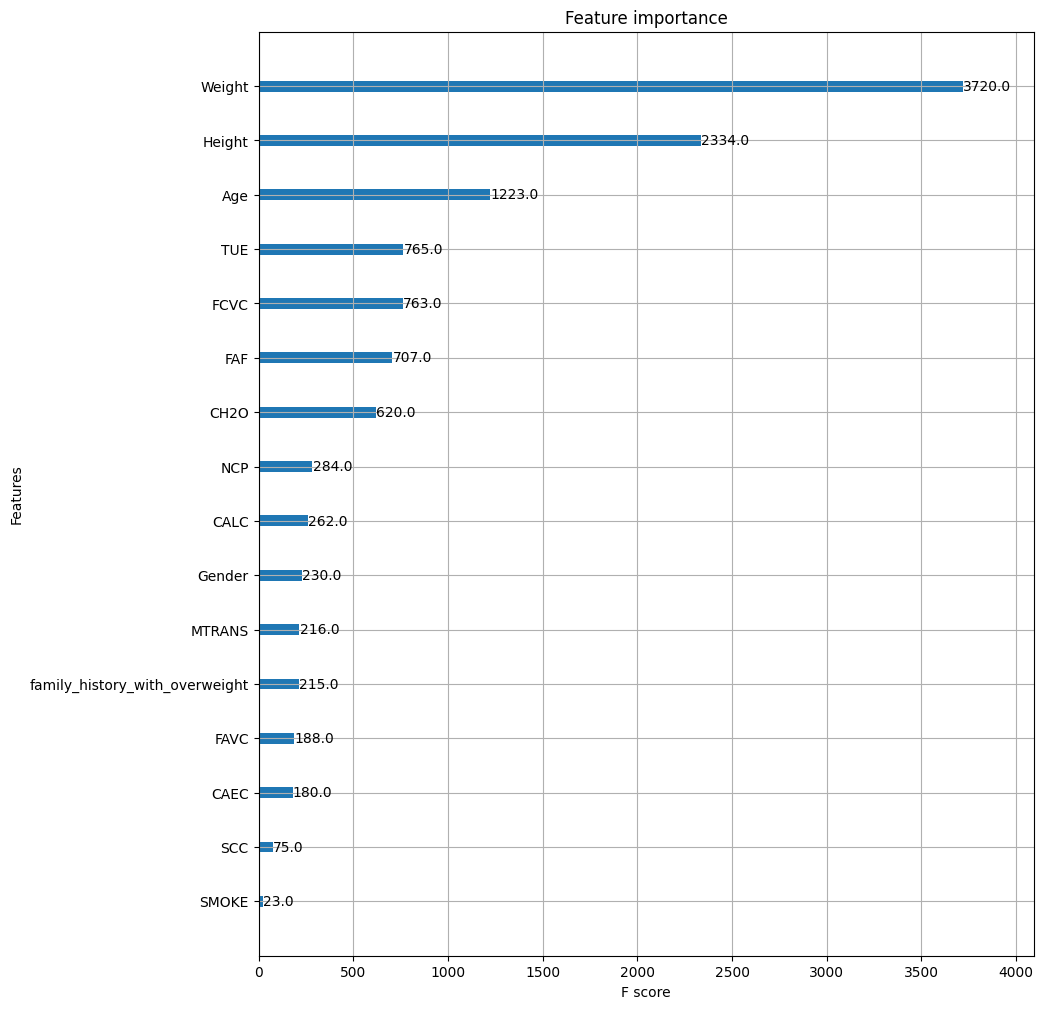

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_clf_o, ax=ax)

# 파이썬래퍼에 그리드 서치 적용

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# 학습 시작 시간 기록
start_time = time.time()

# 파라미터 지정
xgb_param_grid={
    'num_rounds' : [10, 100, 500],
    'eta' : [0.01,0.1,0.15,0.2,0.3],
    'max_depth' : [3,5,7,10,15],
}

eval_list = [
    (d_train, 'train'),
    (d_valid, 'eval')
]

# gridSearchcv 생성
xgb_grid=GridSearchCV(
    estimator = XGBClassifier(random_state=42),
    param_grid = xgb_param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
)

# xgb에 grid 학습시키기
xgb_grid.fit(
    X_train,
    y_train,
    eval_set=eval_sets,
    early_stopping_rounds=50,
    eval_metric='mlogloss',
    verbose=2
)

# 학습 종료 시간 기록
end_time = time.time()

# 학습 소요 시간 계산
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

print("best f1_macro : {0: .4f}".format(xgb_grid.best_score_))
print("best param : ",xgb_grid.best_params_)

[0]	validation_0-mlogloss:1.42527	validation_1-mlogloss:1.44670
[2]	validation_0-mlogloss:0.91059	validation_1-mlogloss:0.96120
[4]	validation_0-mlogloss:0.63049	validation_1-mlogloss:0.70314
[6]	validation_0-mlogloss:0.44640	validation_1-mlogloss:0.52927
[8]	validation_0-mlogloss:0.32212	validation_1-mlogloss:0.41441
[10]	validation_0-mlogloss:0.23955	validation_1-mlogloss:0.33829
[12]	validation_0-mlogloss:0.18208	validation_1-mlogloss:0.28468
[14]	validation_0-mlogloss:0.14158	validation_1-mlogloss:0.24620
[16]	validation_0-mlogloss:0.10928	validation_1-mlogloss:0.21632
[18]	validation_0-mlogloss:0.08817	validation_1-mlogloss:0.19615
[20]	validation_0-mlogloss:0.07166	validation_1-mlogloss:0.17822
[22]	validation_0-mlogloss:0.05905	validation_1-mlogloss:0.16608
[24]	validation_0-mlogloss:0.04931	validation_1-mlogloss:0.15416
[26]	validation_0-mlogloss:0.04170	validation_1-mlogloss:0.14447
[28]	validation_0-mlogloss:0.03579	validation_1-mlogloss:0.13619
[30]	validation_0-mlogloss:0.0

In [22]:
# 학습횟수 100이하로 지정

# 학습 시작 시간 기록
start_time = time.time()

# 파라미터 지정
xgb_param_grid={
    'num_rounds' : [10, 50, 100],
    'eta' : [0.01,0.1,0.15,0.2, 0.3],
    'max_depth' : [3,5,7,10],
}

eval_list = [
    (d_train, 'train'),
    (d_valid, 'eval')
]

# gridSearchcv 생성
xgb_grid=GridSearchCV(
    estimator = XGBClassifier(random_state=42),
    param_grid = xgb_param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
)

# xgb에 grid 학습시키기
xgb_grid.fit(
    X_train,
    y_train,
    eval_set=eval_sets,
    early_stopping_rounds=50,
    eval_metric='mlogloss',
    verbose=2
)

# 학습 종료 시간 기록
end_time = time.time()

# 학습 소요 시간 계산
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

print("best f1_macro : {0: .4f}".format(xgb_grid.best_score_))
print("best param : ",xgb_grid.best_params_)

[0]	validation_0-mlogloss:1.42527	validation_1-mlogloss:1.44670
[2]	validation_0-mlogloss:0.91059	validation_1-mlogloss:0.96120
[4]	validation_0-mlogloss:0.63049	validation_1-mlogloss:0.70314
[6]	validation_0-mlogloss:0.44640	validation_1-mlogloss:0.52927
[8]	validation_0-mlogloss:0.32212	validation_1-mlogloss:0.41441
[10]	validation_0-mlogloss:0.23955	validation_1-mlogloss:0.33829
[12]	validation_0-mlogloss:0.18208	validation_1-mlogloss:0.28468
[14]	validation_0-mlogloss:0.14158	validation_1-mlogloss:0.24620
[16]	validation_0-mlogloss:0.10928	validation_1-mlogloss:0.21632
[18]	validation_0-mlogloss:0.08817	validation_1-mlogloss:0.19615
[20]	validation_0-mlogloss:0.07166	validation_1-mlogloss:0.17822
[22]	validation_0-mlogloss:0.05905	validation_1-mlogloss:0.16608
[24]	validation_0-mlogloss:0.04931	validation_1-mlogloss:0.15416
[26]	validation_0-mlogloss:0.04170	validation_1-mlogloss:0.14447
[28]	validation_0-mlogloss:0.03579	validation_1-mlogloss:0.13619
[30]	validation_0-mlogloss:0.0

In [34]:
import time

# 학습 시작 시간 기록
start_time = time.time()

# 최적의 모델 지정
params = {
    'max_depth': 7, # 각 나무의 최대깊이
    'eta': 0.2, # 학습률(learning rate)
    'objective': 'multi:softmax', # 목적 함수(모델이 예측의 결과를 어떻게 표현할지를 지정하는 함수). logistic 함수를 사용하기 때문에 확률로 결과물을 내어준다.
    'num_class': 7, # 매개변수로 즉, 레이블에 있는 클래스의 개수를 나타내줌
    'eval_matric': 'mlogloss' # 다중분류인 경우 merror를 사용
    }


# 학습 횟수
num_rounds = 10

eval_list = [
    (d_train, 'train'),
    (d_valid, 'eval')
]

best_xgb_model = xgb.train(
    params=params, # 하이퍼 파라미터가 들어있는 딕셔너리
    dtrain = d_train, # 훈련 데이터 Feature + Label
    num_boost_round=num_rounds, # 훈련 횟수
    early_stopping_rounds=50, # 성능 개선(Loss가 낮아지면 성능이 개선됨)이 50라운드 이내에 이루어지지 않으면 학습을 종료
    evals = eval_list # 검증 세트 지정. 여기에서는 훈련 세트와 검증세트에 대한 성능을 한꺼번에 확인
)

# 학습 종료 시간 기록
end_time = time.time()

# 학습 소요 시간 계산
training_time = end_time - start_time
print("Training time:", training_time, "seconds")


[0]	train-mlogloss:1.42527	eval-mlogloss:1.44670
[1]	train-mlogloss:1.12138	eval-mlogloss:1.16035
[2]	train-mlogloss:0.91059	eval-mlogloss:0.96120
[3]	train-mlogloss:0.75236	eval-mlogloss:0.81572
[4]	train-mlogloss:0.63049	eval-mlogloss:0.70314
[5]	train-mlogloss:0.52897	eval-mlogloss:0.60753
[6]	train-mlogloss:0.44640	eval-mlogloss:0.52927
[7]	train-mlogloss:0.37915	eval-mlogloss:0.46699
[8]	train-mlogloss:0.32212	eval-mlogloss:0.41441
[9]	train-mlogloss:0.27681	eval-mlogloss:0.37195
Training time: 0.7945597171783447 seconds


In [24]:
best_pred_props = best_xgb_model.predict(d_test)
print(np.round(best_pred_props[:10], 3))

[5. 0. 5. 4. 5. 2. 2. 1. 2. 4.]


In [25]:
# 오차행렬
from sklearn.metrics import confusion_matrix

y_matrix = confusion_matrix(y_test, best_pred_props)
print("오차 행렬 : \n{}".format(y_matrix))

오차 행렬 : 
[[63  3  2  0  0  0  0]
 [ 2 66  3  1  0  0  0]
 [ 0  8 63  2  0  0  0]
 [ 0  0  3 65  4  0  0]
 [ 0  0  0  1 87  0  0]
 [ 0  0  0  0  4 70  0]
 [ 0  0  0  0  0  1 80]]


In [26]:
# 성능 평가하기
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(best_pred_props, y_test)
precision = precision_score(best_pred_props, y_test, average='macro')
recall = recall_score(best_pred_props, y_test, average='macro')
f1 = f1_score(best_pred_props, y_test, average='macro')

print("정확도 : {}".format(accuracy))
print("정밀도 : {}".format(precision))
print("재현율 : {}".format(recall))
print("F1 : {}".format(f1))

정확도 : 0.9356060606060606
정밀도 : 0.9330236231256912
재현율 : 0.936775931740686
F1 : 0.934340858615737


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

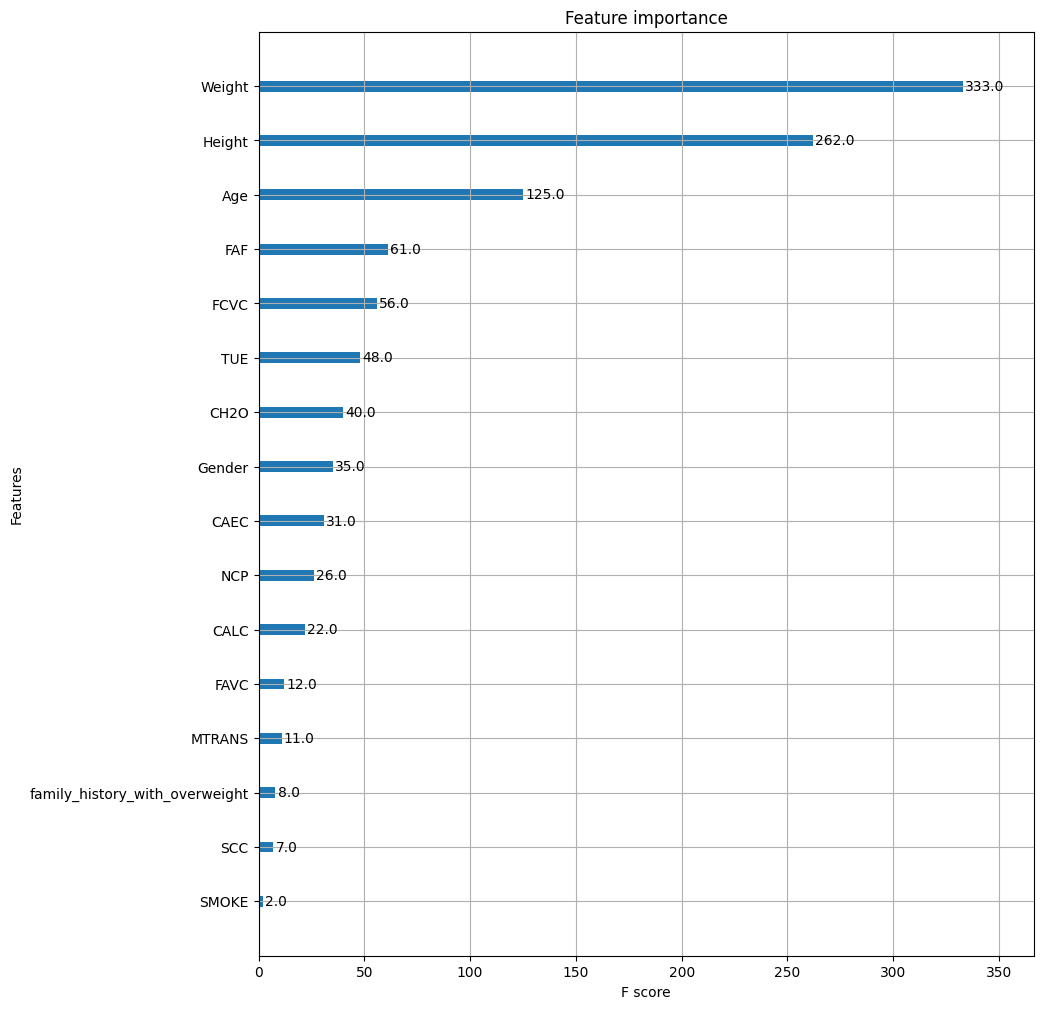

In [27]:
# 최적의 파라미터로 feature 중요도 보기

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(best_xgb_model, ax=ax)

## 싸이킷런 gridsearch 적용

In [28]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import time

# 학습 시작 시간 기록
start_time = time.time()


# 파라미터 지정
xgb_param_grid2={
    'n_estimators' : [10, 100, 500, 1000],
    'learning_rate' : [0.01,0.05,0.1, 0.15, 0.2],
    'max_depth' : [3,5,7,10,15],
}

# eval_sets를 넣어 valid도 같이 학습하기
eval_sets = [
    (X_train, y_train),
    (X_valid, y_valid)
]

# gridSearchcv 생성
xgb_grid2=GridSearchCV(
    estimator = XGBClassifier(random_state=42),
    param_grid = xgb_param_grid2,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
)

# xgb에 grid 학습시키기
xgb_grid2.fit(
    X_train,
    y_train,
    eval_set=eval_sets,
     early_stopping_rounds=50,
    eval_metric='mlogloss',
    verbose=True
)

# 학습 종료 시간 기록
end_time = time.time()

# 학습 소요 시간 계산
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

print("best f1_macro : {0: .4f}".format(xgb_grid.best_score_))
print("best param : ",xgb_grid.best_params_)

[0]	validation_0-mlogloss:1.75384	validation_1-mlogloss:1.75227
[1]	validation_0-mlogloss:1.60617	validation_1-mlogloss:1.60527
[2]	validation_0-mlogloss:1.48505	validation_1-mlogloss:1.48943
[3]	validation_0-mlogloss:1.38282	validation_1-mlogloss:1.38907
[4]	validation_0-mlogloss:1.29555	validation_1-mlogloss:1.30562
[5]	validation_0-mlogloss:1.21639	validation_1-mlogloss:1.22743
[6]	validation_0-mlogloss:1.14875	validation_1-mlogloss:1.16163
[7]	validation_0-mlogloss:1.08959	validation_1-mlogloss:1.10613
[8]	validation_0-mlogloss:1.03453	validation_1-mlogloss:1.05282
[9]	validation_0-mlogloss:0.98250	validation_1-mlogloss:1.00276
[10]	validation_0-mlogloss:0.93723	validation_1-mlogloss:0.95848
[11]	validation_0-mlogloss:0.89804	validation_1-mlogloss:0.92262
[12]	validation_0-mlogloss:0.85993	validation_1-mlogloss:0.88681
[13]	validation_0-mlogloss:0.82133	validation_1-mlogloss:0.85141
[14]	validation_0-mlogloss:0.78435	validation_1-mlogloss:0.81853
[15]	validation_0-mlogloss:0.75211	

In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import time

# 학습 시작 시간 기록
start_time = time.time()


# 파라미터 지정
xgb_param_grid3={
    'n_estimators' : [10, 50, 100],
    'learning_rate' : [0.01,0.05,0.1, 0.15, 0.2],
    'max_depth' : [3,5,7,10,15],
}

# eval_sets를 넣어 valid도 같이 학습하기
eval_sets = [
    (X_train, y_train),
    (X_valid, y_valid)
]

# gridSearchcv 생성
xgb_grid3=GridSearchCV(
    estimator = XGBClassifier(random_state=42),
    param_grid = xgb_param_grid2,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
)

# xgb에 grid 학습시키기
xgb_grid3.fit(
    X_train,
    y_train,
    eval_set=eval_sets,
     early_stopping_rounds=50,
    eval_metric='mlogloss',
    verbose=True
)

# 학습 종료 시간 기록
end_time = time.time()

# 학습 소요 시간 계산
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

print("best f1_macro : {0: .4f}".format(xgb_grid.best_score_))
print("best param : ",xgb_grid.best_params_)

[0]	validation_0-mlogloss:1.75384	validation_1-mlogloss:1.75227
[1]	validation_0-mlogloss:1.60617	validation_1-mlogloss:1.60527
[2]	validation_0-mlogloss:1.48505	validation_1-mlogloss:1.48943
[3]	validation_0-mlogloss:1.38282	validation_1-mlogloss:1.38907
[4]	validation_0-mlogloss:1.29555	validation_1-mlogloss:1.30562
[5]	validation_0-mlogloss:1.21639	validation_1-mlogloss:1.22743
[6]	validation_0-mlogloss:1.14875	validation_1-mlogloss:1.16163
[7]	validation_0-mlogloss:1.08959	validation_1-mlogloss:1.10613
[8]	validation_0-mlogloss:1.03453	validation_1-mlogloss:1.05282
[9]	validation_0-mlogloss:0.98250	validation_1-mlogloss:1.00276
[10]	validation_0-mlogloss:0.93723	validation_1-mlogloss:0.95848
[11]	validation_0-mlogloss:0.89804	validation_1-mlogloss:0.92262
[12]	validation_0-mlogloss:0.85993	validation_1-mlogloss:0.88681
[13]	validation_0-mlogloss:0.82133	validation_1-mlogloss:0.85141
[14]	validation_0-mlogloss:0.78435	validation_1-mlogloss:0.81853
[15]	validation_0-mlogloss:0.75211	

In [30]:
# 최적의 모델 지정
best_model2 = xgb_grid3.best_estimator_

# 최적의 모델로 test데이터 예측
grid_pred2 = best_model2.predict(X_test)

grid_pred2[:10]

array([5, 0, 5, 4, 5, 2, 2, 1, 2, 4])

In [31]:
grid_matrix = confusion_matrix(y_test, grid_pred2)
print("오차 행렬 : \n{}".format(grid_matrix))

# 성능 평가하기
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(grid_pred2, y_test)
precision = precision_score(grid_pred2, y_test, average='macro')
recall = recall_score(grid_pred2, y_test, average='macro')
f1 = f1_score(grid_pred2, y_test, average='macro')

print("정확도 : {}".format(accuracy))
print("정밀도 : {}".format(precision))
print("재현율 : {}".format(recall))
print("F1 : {}".format(f1))

오차 행렬 : 
[[63  5  0  0  0  0  0]
 [ 2 67  3  0  0  0  0]
 [ 0  4 66  3  0  0  0]
 [ 0  1  1 66  4  0  0]
 [ 0  0  0  0 88  0  0]
 [ 0  0  0  0  4 70  0]
 [ 0  0  0  0  1  0 80]]
정확도 : 0.946969696969697
정밀도 : 0.9444860952046017
재현율 : 0.949422288027654
F1 : 0.946186687057895


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

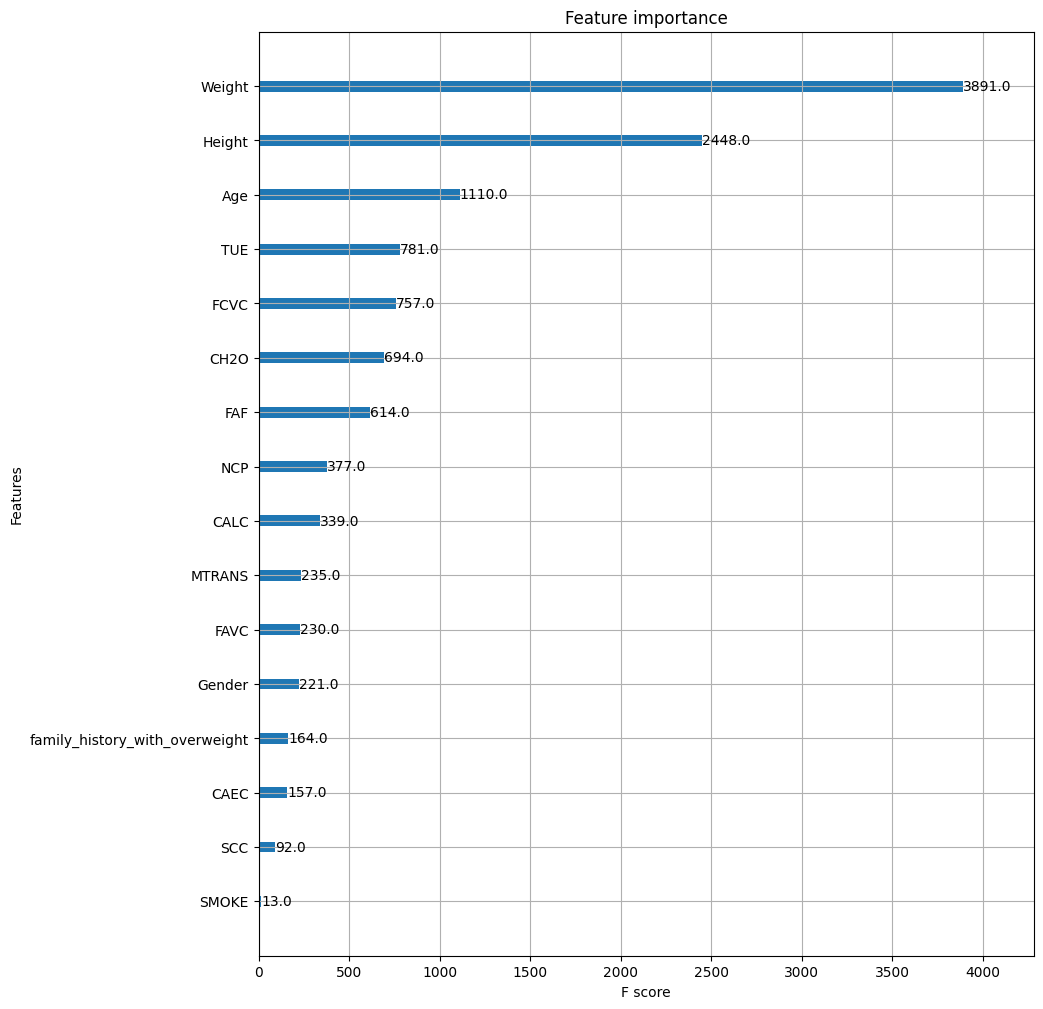

In [32]:
# 최적의 파라미터로 feature 중요도 보기

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(best_model2, ax=ax)